In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
# Create Spark session
spark = SparkSession.builder.appName('ml-cls').getOrCreate()


In [4]:
# Load dataset
df = spark.read.csv('/content/HeartDisease.csv', header=True, inferSchema=True)

# Show schema of the DataFrame
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [5]:
# Drop non-relevant columns
df = df.drop('sex', 'cp', 'slope')

In [6]:
X = df.drop('target')  # Remove label from the features

In [7]:
# Feature engineering: VectorAssembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=X.columns, outputCol='features')
transformed_data = assembler.transform(df)

In [8]:
# Show transformed data
transformed_data.show(5, truncate=False)

+---+--------+----+---+-------+-------+-----+-------+---+----+------+------------------------------------------------+
|age|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|ca |thal|target|features                                        |
+---+--------+----+---+-------+-------+-----+-------+---+----+------+------------------------------------------------+
|52 |125     |212 |0  |1      |168    |0    |1.0    |2  |3   |0     |[52.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,3.0]|
|53 |140     |203 |1  |0      |155    |1    |3.1    |0  |3   |0     |[53.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,3.0]|
|70 |145     |174 |0  |1      |125    |1    |2.6    |0  |3   |0     |[70.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,3.0]|
|61 |148     |203 |0  |1      |161    |0    |0.0    |1  |3   |0     |[61.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,1.0,3.0]|
|62 |138     |294 |1  |1      |106    |0    |1.9    |3  |2   |0     |[62.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,3.0,2.0]|
+---+--------+----+---+-------+-------+-----+---

In [10]:
from rich.console import Console
# Initialize a Console for rich formatting
console = Console()

In [13]:
# Function to evaluate the model with different train-test splits
def evaluate_model(test_ratio, train_ratio):
    print('#################################################################################################################################')
    console.print(
        f"[bold underline]This is for {int(test_ratio * 100)}% Test and {int(train_ratio * 100)}% Train[/bold underline]",
        justify="center",
        style="blue"
    )
    print('#################################################################################################################################')
    # Split the data into train and test sets
    (X_train, X_test) = transformed_data.randomSplit([train_ratio, test_ratio])

    # Initialize Decision Tree model
    dt = DecisionTreeClassifier(featuresCol='features', labelCol='target')

    # Train the model
    dt_model = dt.fit(X_train)

    # Make predictions on the test data
    predictions = dt_model.transform(X_test)

    # Show some predictions
    predictions.select('age', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'thal', 'prediction').show(5)

    # Group by the 'target' and 'prediction' columns to see the counts
    predictions.groupBy('target', 'prediction').count().show()

    # Extract true labels and predicted labels as lists
    y_true = predictions.select('target').rdd.flatMap(list).collect()
    y_pred = predictions.select('prediction').rdd.flatMap(list).collect()

    # Calculate confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)

    # Print confusion matrix
    print(f"Confusion Matrix (Test ratio {test_ratio}):")
    print(cm)

    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)

    # Annotate each cell in the confusion matrix
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

    # Calculate metrics from confusion matrix
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)

    # Print metrics
    print(f'Metrics computed from a confusion matrix (Test ratio {test_ratio}):')
    print("Accuracy:\t", accuracy)
    print("Classification Error:", 1 - accuracy)
    print("Sensitivity/Recall:\t", recall)
    print("Specificity:\t", specificity)
    print("Precision:\t", precision)
    print("False Positive Rate:", 1 - TN / (TN + FP))

#################################################################################################################################


                                        This is for 20% Test and 80% Train                                         

#################################################################################################################################
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
|age|trestbps|chol|fbs|restecg|thalach|exang|oldpeak| ca|thal|prediction|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
| 29|     130| 204|  0|      0|    202|    0|    0.0|  0|   2|       1.0|
| 35|     120| 198|  0|      1|    130|    1|    1.6|  0|   3|       0.0|
| 35|     126| 282|  0|      0|    156|    1|    0.0|  0|   3|       0.0|
| 37|     120| 215|  0|      1|    170|    0|    0.0|  0|   2|       1.0|
| 37|     130| 250|  0|      1|    187|    0|    3.5|  0|   2|       1.0|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
only showing top 5 rows

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       0.0|    9|
|     0|       0.0|   80|
|     1|       1.0|   88|
|     0|       1.0|   2

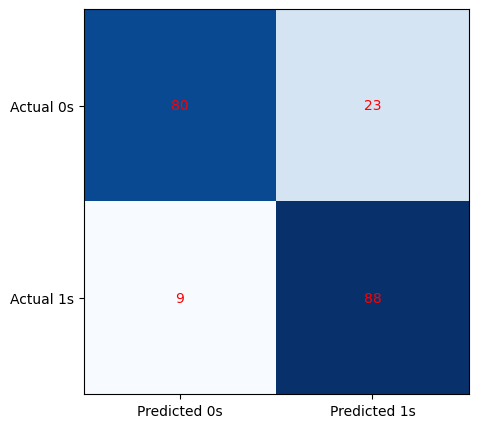

Metrics computed from a confusion matrix (Test ratio 0.2):
Accuracy:	 0.84
Classification Error: 0.16000000000000003
Sensitivity/Recall:	 0.9072164948453608
Specificity:	 0.7766990291262136
Precision:	 0.7927927927927928
False Positive Rate: 0.22330097087378642
#################################################################################################################################


                                        This is for 30% Test and 70% Train                                         

#################################################################################################################################
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
|age|trestbps|chol|fbs|restecg|thalach|exang|oldpeak| ca|thal|prediction|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
| 29|     130| 204|  0|      0|    202|    0|    0.0|  0|   2|       1.0|
| 29|     130| 204|  0|      0|    202|    0|    0.0|  0|   2|       1.0|
| 34|     118| 182|  0|      0|    174|    0|    0.0|  0|   2|       1.0|
| 34|     118| 210|  0|      1|    192|    0|    0.7|  0|   2|       1.0|
| 34|     118| 210|  0|      1|    192|    0|    0.7|  0|   2|       1.0|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
only showing top 5 rows

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       0.0|   16|
|     0|       0.0|  118|
|     1|       1.0|  142|
|     0|       1.0|   2

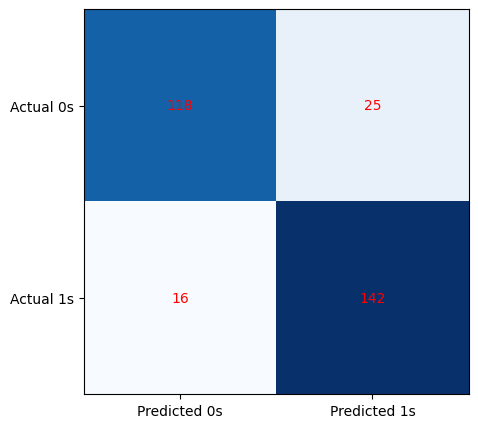

Metrics computed from a confusion matrix (Test ratio 0.3):
Accuracy:	 0.8637873754152824
Classification Error: 0.1362126245847176
Sensitivity/Recall:	 0.8987341772151899
Specificity:	 0.8251748251748252
Precision:	 0.8502994011976048
False Positive Rate: 0.1748251748251748
#################################################################################################################################


                                        This is for 35% Test and 65% Train                                         

#################################################################################################################################
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
|age|trestbps|chol|fbs|restecg|thalach|exang|oldpeak| ca|thal|prediction|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
| 29|     130| 204|  0|      0|    202|    0|    0.0|  0|   2|       1.0|
| 34|     118| 182|  0|      0|    174|    0|    0.0|  0|   2|       1.0|
| 34|     118| 182|  0|      0|    174|    0|    0.0|  0|   2|       1.0|
| 35|     120| 198|  0|      1|    130|    1|    1.6|  0|   3|       0.0|
| 35|     122| 192|  0|      1|    174|    0|    0.0|  0|   2|       1.0|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
only showing top 5 rows

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       0.0|   19|
|     0|       0.0|  150|
|     1|       1.0|  172|
|     0|       1.0|   3

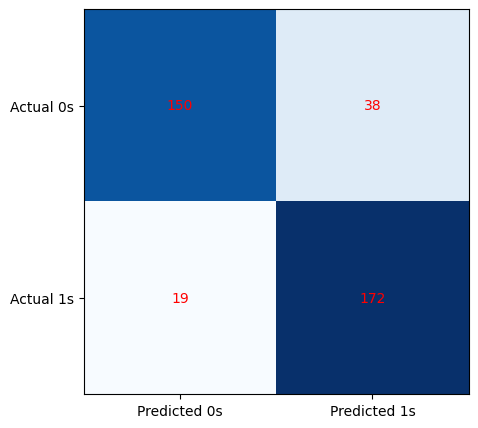

Metrics computed from a confusion matrix (Test ratio 0.35):
Accuracy:	 0.8496042216358839
Classification Error: 0.1503957783641161
Sensitivity/Recall:	 0.900523560209424
Specificity:	 0.7978723404255319
Precision:	 0.819047619047619
False Positive Rate: 0.2021276595744681


In [14]:
# Evaluate the model with different splits
evaluate_model(0.2, 0.8)  # 20% test, 80% train
evaluate_model(0.3, 0.7)  # 30% test, 70% train
evaluate_model(0.35, 0.65)  # 35% test, 65% train